# 🔍 Análisis de Mutual Information
## Diagnóstico de Poder Predictivo de Features

**Objetivo:** Determinar si las variables disponibles tienen información útil para predecir violencia atípica.

**Mutual Information (MI)** mide la dependencia entre cada feature y el target:
- **MI = 0:** Feature completamente independiente del target (no útil)
- **MI > 0:** Feature tiene información sobre el target
- **MI alto:** Feature muy informativa

**Umbral crítico:** Si TODAS las features tienen MI < 0.05, el problema puede ser fundamentalmente impredecible.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler
import warnings


from pathlib import Path  # For cross-platform file path handling
import yaml  # To read YAML configuration files

# Load directory paths from configuration file
with open('paths.yml', 'r') as file:
    paths = yaml.safe_load(file)  # Read and parse YAML file

# Create Path objects for each directory
raw = Path(paths['data']['raw'])  # Directory with raw data
temp = Path(paths['data']['temp'])  # Directory with temporary processed data
processed = Path(paths['data']['processed'])  # Directory with final processed data
model = Path(paths['outputs']['model'])

warnings.filterwarnings('ignore')


warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

## 1. Cargar Datos

**IMPORTANTE:** Usa los mismos datos procesados que en tu notebook principal (después de imputación, antes de estandarización)

In [2]:
# CONFIGURACIÓN - Ajusta según tu notebook principal
DATA_PATH = processed/'db_no_jep.parquet'
TARGET_COL = 'atypical_violence'
TIME_COL = 'quarter'
MUNICIPALITY_COL = 'mun_code'

COLS_TO_EXCLUDE = [
    'atypical_violence',
    'mun_code', 'quarter',
    'iacv', 'iacv_t', 'qty_iacv', 'qty_01', 'qty_02', 'qty_03', 'qty_04', 'qty_05',
    'population',
    '_merge'
]

TRAIN_PROP = 0.70
RANDOM_STATE = 42

In [3]:
# Cargar datos
df = pd.read_parquet(DATA_PATH)

# Extraer año y trimestre
df['año'] = df[TIME_COL].astype(str).str[:4].astype(int)
df['trimestre'] = df[TIME_COL].astype(str).str[-1].astype(int)
df['periodo_num'] = df['año'] * 10 + df['trimestre']
df = df.sort_values(['periodo_num', MUNICIPALITY_COL]).reset_index(drop=True)

print(f"Dataset cargado: {df.shape}")
print(f"Prevalencia de {TARGET_COL}: {df[TARGET_COL].mean():.2%}")

Dataset cargado: (76184, 70)
Prevalencia de atypical_violence: 18.73%


In [4]:
# Crear splits temporales
periodos_unicos = sorted(df[TIME_COL].unique())
n_periodos = len(periodos_unicos)
train_end_idx = int(n_periodos * TRAIN_PROP)

train_periods = periodos_unicos[:train_end_idx]
train_mask = df[TIME_COL].isin(train_periods)

print(f"Periodos de entrenamiento: {len(train_periods)}")
print(f"Desde {train_periods[0]} hasta {train_periods[-1]}")
print(f"Observaciones en train: {train_mask.sum():,}")

Periodos de entrenamiento: 47
Desde 2006Q1 hasta 2017Q3
Observaciones en train: 52,643


In [5]:
# Separar features y target
derived_cols = ['año', 'trimestre', 'periodo_num']
all_cols_to_exclude = list(set(COLS_TO_EXCLUDE + derived_cols))
cols_excluir_existentes = [col for col in all_cols_to_exclude if col in df.columns]

feature_cols = [col for col in df.columns if col not in cols_excluir_existentes]

X = df[feature_cols].copy()
y = df[TARGET_COL].copy()

X_train = X[train_mask].copy()
y_train = y[train_mask].copy()

print(f"\nFeatures disponibles: {len(feature_cols)}")
print(f"X_train shape: {X_train.shape}")
print(f"y_train prevalencia: {y_train.mean():.2%}")


Features disponibles: 54
X_train shape: (52643, 54)
y_train prevalencia: 18.26%


In [6]:
# Imputación simple (mismo proceso que notebook principal)
from sklearn.impute import SimpleImputer

numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X_train.select_dtypes(exclude=[np.number]).columns.tolist()

if len(categorical_cols) > 0:
    print(f"⚠️  {len(categorical_cols)} variables categóricas detectadas:")
    print(categorical_cols)
    print("\nConsideración: MI funciona mejor con variables numéricas.")
    print("Opciones: (1) Excluir categóricas, (2) One-Hot Encoding, (3) Label Encoding")

# Imputar solo numéricas para este análisis
if len(numeric_cols) > 0:
    num_imputer = SimpleImputer(strategy='median')
    X_train[numeric_cols] = num_imputer.fit_transform(X_train[numeric_cols])
    print(f"\n✓ Imputación completada en {len(numeric_cols)} features numéricas")

# Para MI, trabajar solo con features numéricas
X_train_numeric = X_train[numeric_cols].copy()
feature_cols_numeric = numeric_cols

print(f"\nFeatures numéricas para MI: {len(feature_cols_numeric)}")


✓ Imputación completada en 54 features numéricas

Features numéricas para MI: 54


## 2. Cálculo de Mutual Information

**Parámetros importantes:**
- `discrete_features=False`: Todas son continuas (después de imputación)
- `n_neighbors=3`: Vecinos para estimación (default)
- `random_state`: Para reproducibilidad

In [7]:
print("Calculando Mutual Information...")
print("Esto puede tomar varios minutos dependiendo del tamaño de los datos.\n")

# Calcular MI
mi_scores = mutual_info_classif(
    X_train_numeric, 
    y_train,
    discrete_features=False,  # Todas continuas
    n_neighbors=3,             # Vecinos para estimación
    random_state=RANDOM_STATE
)

print("✓ Cálculo completado")

Calculando Mutual Information...
Esto puede tomar varios minutos dependiendo del tamaño de los datos.

✓ Cálculo completado


In [8]:
# Crear DataFrame de resultados
mi_df = pd.DataFrame({
    'Feature': feature_cols_numeric,
    'MI_Score': mi_scores
}).sort_values('MI_Score', ascending=False)

print(f"\n{'='*70}")
print("ESTADÍSTICAS DE MUTUAL INFORMATION")
print(f"{'='*70}")
print(f"\nTotal features analizadas: {len(mi_scores)}")
print(f"\nEstadísticas de MI:")
print(f"  Media:    {mi_scores.mean():.6f}")
print(f"  Mediana:  {np.median(mi_scores):.6f}")
print(f"  Std:      {mi_scores.std():.6f}")
print(f"  Mínimo:   {mi_scores.min():.6f}")
print(f"  Máximo:   {mi_scores.max():.6f}")

# Umbrales de interpretación
very_low = (mi_scores < 0.01).sum()
low = ((mi_scores >= 0.01) & (mi_scores < 0.05)).sum()
moderate = ((mi_scores >= 0.05) & (mi_scores < 0.10)).sum()
high = (mi_scores >= 0.10).sum()

print(f"\nDistribución por nivel de MI:")
print(f"  Muy bajo  (MI < 0.01):  {very_low} features ({very_low/len(mi_scores)*100:.1f}%)")
print(f"  Bajo      (0.01-0.05):  {low} features ({low/len(mi_scores)*100:.1f}%)")
print(f"  Moderado  (0.05-0.10):  {moderate} features ({moderate/len(mi_scores)*100:.1f}%)")
print(f"  Alto      (MI >= 0.10): {high} features ({high/len(mi_scores)*100:.1f}%)")


ESTADÍSTICAS DE MUTUAL INFORMATION

Total features analizadas: 54

Estadísticas de MI:
  Media:    0.004784
  Mediana:  0.004205
  Std:      0.003738
  Mínimo:   0.000000
  Máximo:   0.011872

Distribución por nivel de MI:
  Muy bajo  (MI < 0.01):  50 features (92.6%)
  Bajo      (0.01-0.05):  4 features (7.4%)
  Moderado  (0.05-0.10):  0 features (0.0%)
  Alto      (MI >= 0.10): 0 features (0.0%)


## 3. Interpretación de Resultados

In [9]:
# Diagnóstico automático
print(f"\n{'='*70}")
print("DIAGNÓSTICO AUTOMÁTICO")
print(f"{'='*70}\n")

if mi_scores.max() < 0.05:
    print("🔴 ALERTA CRÍTICA: Señal predictiva MUY DÉBIL")
    print("   - TODAS las features tienen MI < 0.05")
    print("   - El problema puede ser fundamentalmente impredecible")
    print("\nPosibles causas:")
    print("   1. Variables clave no incluidas en el dataset")
    print("   2. Violencia atípica es mayormente aleatoria/estocástica")
    print("   3. Features necesitan transformación (log, interacciones, etc.)")
    print("   4. Rezagos temporales insuficientes")
    print("\nRecomendaciones:")
    print("   - Feature engineering más agresivo")
    print("   - Revisar definición de 'violencia atípica'")
    print("   - Considerar modelos no-lineales (Random Forest, XGBoost)")
    print("   - Agregar variables espaciales de contagio")

elif mi_scores.max() < 0.10:
    print("🟡 ADVERTENCIA: Señal predictiva DÉBIL")
    print(f"   - MI máximo: {mi_scores.max():.4f}")
    print(f"   - Features con MI > 0.05: {moderate}")
    print("\nExpectativas realistas:")
    print("   - AUPRC esperado: 0.55 - 0.65")
    print("   - F1-Score esperado: 0.40 - 0.55")
    print("\nRecomendaciones:")
    print("   - Feature engineering con interacciones")
    print("   - Modelos ensemble para capturar patrones débiles")
    print("   - Considerar variables de contexto espacial")

elif mi_scores.max() >= 0.10:
    print("🟢 BUENAS NOTICIAS: Señal predictiva DETECTABLE")
    print(f"   - MI máximo: {mi_scores.max():.4f}")
    print(f"   - Features con MI > 0.10: {high}")
    print(f"   - Features con MI > 0.05: {moderate + high}")
    print("\nExpectativas:")
    print("   - AUPRC esperado: 0.65 - 0.80+")
    print("   - F1-Score esperado: 0.50 - 0.70+")
    print("\nRecomendaciones:")
    print("   - Enfocarse en top features con MI alto")
    print("   - Feature selection puede mejorar performance")
    print("   - Modelos lineales pueden funcionar bien")

# Comparar con baseline
baseline_mi = -y_train.mean() * np.log2(y_train.mean()) - (1-y_train.mean()) * np.log2(1-y_train.mean())
print(f"\nReferencia - Entropía de {TARGET_COL}: {baseline_mi:.4f}")
print(f"  (Máxima MI posible con target binario)")
print(f"\nMejor feature captura {mi_scores.max()/baseline_mi*100:.1f}% de la información del target")


DIAGNÓSTICO AUTOMÁTICO

🔴 ALERTA CRÍTICA: Señal predictiva MUY DÉBIL
   - TODAS las features tienen MI < 0.05
   - El problema puede ser fundamentalmente impredecible

Posibles causas:
   1. Variables clave no incluidas en el dataset
   2. Violencia atípica es mayormente aleatoria/estocástica
   3. Features necesitan transformación (log, interacciones, etc.)
   4. Rezagos temporales insuficientes

Recomendaciones:
   - Feature engineering más agresivo
   - Revisar definición de 'violencia atípica'
   - Considerar modelos no-lineales (Random Forest, XGBoost)
   - Agregar variables espaciales de contagio

Referencia - Entropía de atypical_violence: 0.6857
  (Máxima MI posible con target binario)

Mejor feature captura 1.7% de la información del target


## 4. Visualización de Top Features

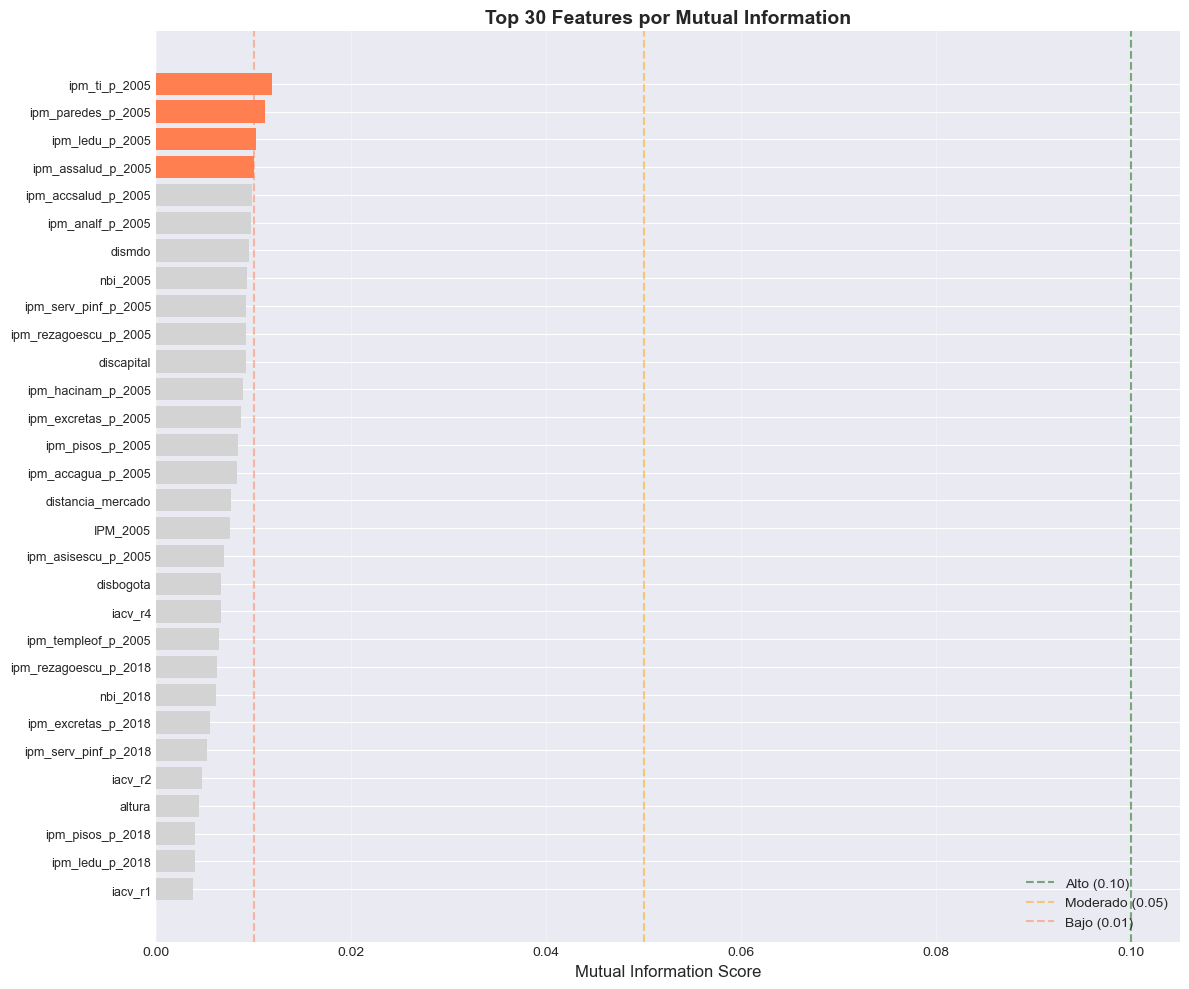


Top 30 Features:
              Feature  MI_Score
        ipm_ti_p_2005  0.011872
   ipm_paredes_p_2005  0.011181
      ipm_ledu_p_2005  0.010247
   ipm_assalud_p_2005  0.010056
  ipm_accsalud_p_2005  0.009841
     ipm_analf_p_2005  0.009773
               dismdo  0.009494
             nbi_2005  0.009335
 ipm_serv_pinf_p_2005  0.009247
ipm_rezagoescu_p_2005  0.009231
           discapital  0.009207
   ipm_hacinam_p_2005  0.008963
  ipm_excretas_p_2005  0.008749
     ipm_pisos_p_2005  0.008438
   ipm_accagua_p_2005  0.008267
    distancia_mercado  0.007683
             IPM_2005  0.007622
  ipm_asisescu_p_2005  0.006982
            disbogota  0.006662
              iacv_r4  0.006617
  ipm_templeof_p_2005  0.006447
ipm_rezagoescu_p_2018  0.006246
             nbi_2018  0.006129
  ipm_excretas_p_2018  0.005500
 ipm_serv_pinf_p_2018  0.005270
              iacv_r2  0.004683
               altura  0.004385
     ipm_pisos_p_2018  0.004025
      ipm_ledu_p_2018  0.003962
              iacv_r1 

In [10]:
# Top 30 features por MI
top_n = min(30, len(mi_df))
top_features = mi_df.head(top_n)

fig, ax = plt.subplots(figsize=(12, 10))

# Barplot horizontal
colors = ['darkgreen' if x >= 0.10 else 'orange' if x >= 0.05 else 'coral' if x >= 0.01 else 'lightgray' 
          for x in top_features['MI_Score']]

ax.barh(range(len(top_features)), top_features['MI_Score'], color=colors)
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['Feature'], fontsize=9)
ax.invert_yaxis()
ax.set_xlabel('Mutual Information Score', fontsize=12)
ax.set_title(f'Top {top_n} Features por Mutual Information', fontsize=14, fontweight='bold')
ax.axvline(0.10, color='darkgreen', linestyle='--', alpha=0.5, label='Alto (0.10)')
ax.axvline(0.05, color='orange', linestyle='--', alpha=0.5, label='Moderado (0.05)')
ax.axvline(0.01, color='coral', linestyle='--', alpha=0.5, label='Bajo (0.01)')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print(f"\nTop {top_n} Features:")
print(top_features.to_string(index=False))

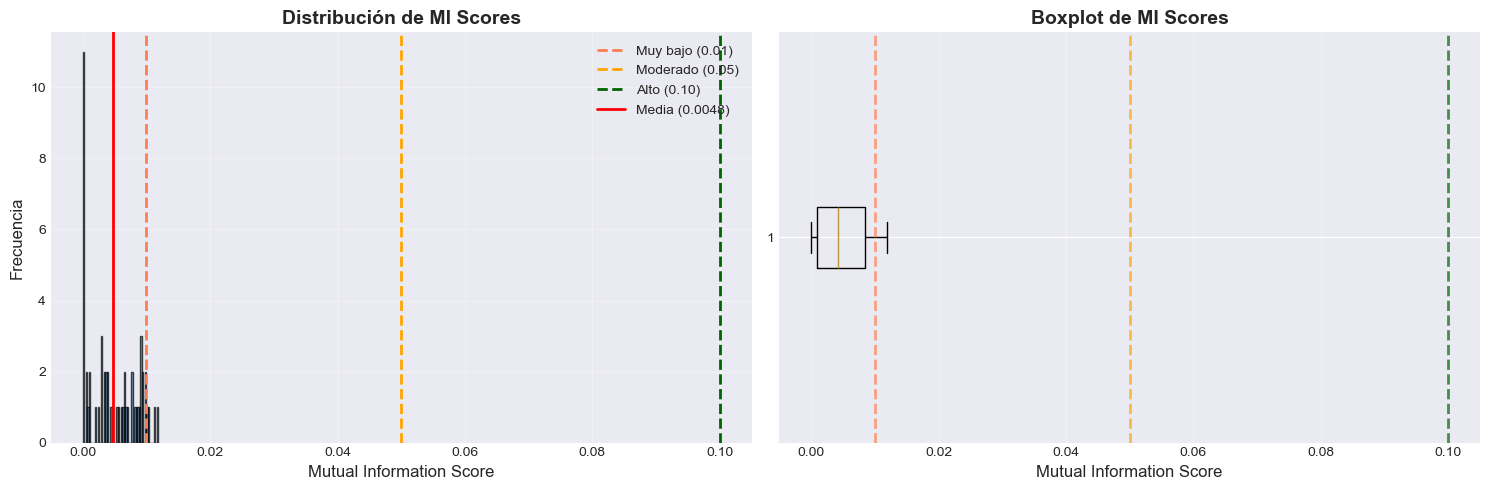

In [11]:
# Distribución de MI scores
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Histograma
ax1.hist(mi_scores, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
ax1.axvline(0.01, color='coral', linestyle='--', linewidth=2, label='Muy bajo (0.01)')
ax1.axvline(0.05, color='orange', linestyle='--', linewidth=2, label='Moderado (0.05)')
ax1.axvline(0.10, color='darkgreen', linestyle='--', linewidth=2, label='Alto (0.10)')
ax1.axvline(mi_scores.mean(), color='red', linestyle='-', linewidth=2, label=f'Media ({mi_scores.mean():.4f})')
ax1.set_xlabel('Mutual Information Score', fontsize=12)
ax1.set_ylabel('Frecuencia', fontsize=12)
ax1.set_title('Distribución de MI Scores', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Boxplot
ax2.boxplot(mi_scores, vert=False)
ax2.axvline(0.01, color='coral', linestyle='--', linewidth=2, alpha=0.7)
ax2.axvline(0.05, color='orange', linestyle='--', linewidth=2, alpha=0.7)
ax2.axvline(0.10, color='darkgreen', linestyle='--', linewidth=2, alpha=0.7)
ax2.set_xlabel('Mutual Information Score', fontsize=12)
ax2.set_title('Boxplot de MI Scores', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

## 5. Análisis por Tipo de Variable

Agrupar features por categoría para identificar qué tipo de información es más predictiva.


MUTUAL INFORMATION POR CATEGORÍA DE VARIABLE

                     Count     Media   Mediana       Max       Min
Categoria                                                         
Otro                     3  0.008454  0.009207  0.009494  0.006662
Pobreza_Desarrollo      32  0.006149  0.006347  0.011872  0.000000
Violencia_Historica      4  0.004704  0.004221  0.006617  0.003756
Demografico              1  0.003059  0.003059  0.003059  0.003059
Geografico               4  0.003017  0.002192  0.007683  0.000000
Economico_Fiscal         5  0.000310  0.000000  0.001064  0.000000
Educacion                3  0.000194  0.000000  0.000583  0.000000
Cultivos_Ilicitos        2  0.000050  0.000050  0.000101  0.000000


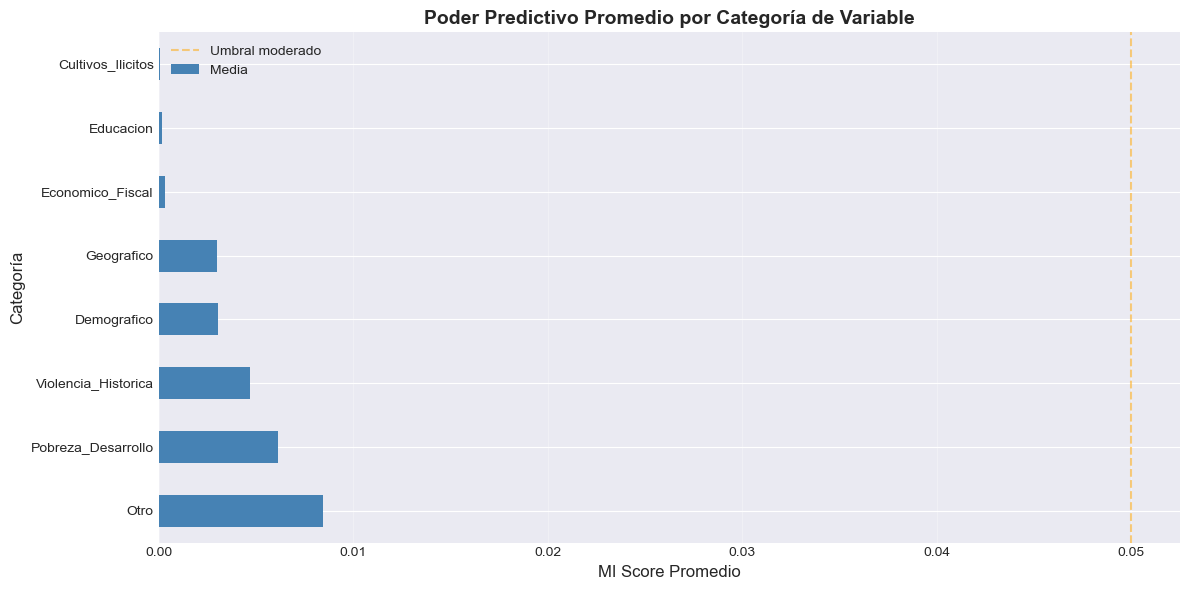

In [12]:
# Clasificar features por tipo (ajustar según tu dataset)
def classify_feature(name):
    name_lower = name.lower()
    
    if any(x in name_lower for x in ['iacv', 'qty']):
        return 'Violencia_Historica'
    elif any(x in name_lower for x in ['ipm', 'nbi']):
        return 'Pobreza_Desarrollo'
    elif any(x in name_lower for x in ['y_corr', 'df_', 'deuda', 'ing']):
        return 'Economico_Fiscal'
    elif any(x in name_lower for x in ['women', 'population']):
        return 'Demografico'
    elif any(x in name_lower for x in ['coca', 'amapola']):
        return 'Cultivos_Ilicitos'
    elif any(x in name_lower for x in ['altura', 'area', 'dist', 'rural']):
        return 'Geografico'
    elif any(x in name_lower for x in ['docen', 'alumn', 's11']):
        return 'Educacion'
    else:
        return 'Otro'

mi_df['Categoria'] = mi_df['Feature'].apply(classify_feature)

# Estadísticas por categoría
categoria_stats = mi_df.groupby('Categoria')['MI_Score'].agg([
    ('Count', 'count'),
    ('Media', 'mean'),
    ('Mediana', 'median'),
    ('Max', 'max'),
    ('Min', 'min')
]).sort_values('Media', ascending=False)

print("\n" + "="*70)
print("MUTUAL INFORMATION POR CATEGORÍA DE VARIABLE")
print("="*70 + "\n")
print(categoria_stats)

# Visualizar
fig, ax = plt.subplots(figsize=(12, 6))

categoria_stats['Media'].plot(kind='barh', ax=ax, color='steelblue')
ax.set_xlabel('MI Score Promedio', fontsize=12)
ax.set_ylabel('Categoría', fontsize=12)
ax.set_title('Poder Predictivo Promedio por Categoría de Variable', 
             fontsize=14, fontweight='bold')
ax.axvline(0.05, color='orange', linestyle='--', alpha=0.5, label='Umbral moderado')
ax.legend()
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

## 6. Features Recomendadas para Feature Selection

In [13]:
# Features con señal útil (MI >= 0.05)
useful_features = mi_df[mi_df['MI_Score'] >= 0.05].copy()

print(f"\n{'='*70}")
print("FEATURES RECOMENDADAS PARA INCLUIR EN EL MODELO")
print(f"{'='*70}\n")

if len(useful_features) == 0:
    print("❌ NINGUNA feature tiene MI >= 0.05")
    print("\nRecomendación: NO hacer feature selection. Usar todas las variables.")
    print("El modelo necesita toda la información disponible, aunque sea débil.")
elif len(useful_features) < 10:
    print(f"⚠️  Solo {len(useful_features)} features tienen MI >= 0.05")
    print("\nFeatures útiles:")
    print(useful_features[['Feature', 'MI_Score', 'Categoria']].to_string(index=False))
    print("\nRecomendación: Usar estas features + algunas adicionales por contexto teórico.")
else:
    print(f"✓ {len(useful_features)} features tienen MI >= 0.05")
    print("\nTop 20 features recomendadas:")
    print(useful_features.head(20)[['Feature', 'MI_Score', 'Categoria']].to_string(index=False))
    print(f"\n... y {max(0, len(useful_features)-20)} features más")
    print("\nRecomendación: Usar estas features como base del modelo.")

# Guardar lista de features recomendadas
recommended_features = useful_features['Feature'].tolist()
print(f"\nTotal features recomendadas: {len(recommended_features)}")


FEATURES RECOMENDADAS PARA INCLUIR EN EL MODELO

❌ NINGUNA feature tiene MI >= 0.05

Recomendación: NO hacer feature selection. Usar todas las variables.
El modelo necesita toda la información disponible, aunque sea débil.

Total features recomendadas: 0


## 7. Exportar Resultados

In [15]:
# Exportar resultados completos
import os
from datetime import datetime

RESULTS_DIR = '/Users/juandiegoheredianino/Library/CloudStorage/OneDrive-Universidaddelosandes/early-warning-atypical-violence-forecast/outputs/previous/MI'
os.makedirs(RESULTS_DIR, exist_ok=True)

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

# Archivo 1: Todos los MI scores
mi_file = os.path.join(RESULTS_DIR, f'mutual_information_scores_{timestamp}.csv')
mi_df.to_csv(mi_file, index=False)
print(f"✓ MI scores exportados: {mi_file}")

# Archivo 2: Features recomendadas
rec_file = os.path.join(RESULTS_DIR, f'recommended_features_{timestamp}.txt')
with open(rec_file, 'w') as f:
    f.write("# FEATURES RECOMENDADAS (MI >= 0.05)\n")
    f.write(f"# Generado: {timestamp}\n")
    f.write(f"# Total: {len(recommended_features)}\n\n")
    for feat in recommended_features:
        f.write(f"{feat}\n")
print(f"✓ Features recomendadas exportadas: {rec_file}")

# Archivo 3: Estadísticas por categoría
cat_file = os.path.join(RESULTS_DIR, f'mi_by_category_{timestamp}.csv')
categoria_stats.to_csv(cat_file)
print(f"✓ Estadísticas por categoría exportadas: {cat_file}")

print("\n" + "="*70)
print("ANÁLISIS DE MUTUAL INFORMATION COMPLETADO")
print("="*70)

✓ MI scores exportados: /Users/juandiegoheredianino/Library/CloudStorage/OneDrive-Universidaddelosandes/early-warning-atypical-violence-forecast/outputs/previous/MI/mutual_information_scores_20260131_142950.csv
✓ Features recomendadas exportadas: /Users/juandiegoheredianino/Library/CloudStorage/OneDrive-Universidaddelosandes/early-warning-atypical-violence-forecast/outputs/previous/MI/recommended_features_20260131_142950.txt
✓ Estadísticas por categoría exportadas: /Users/juandiegoheredianino/Library/CloudStorage/OneDrive-Universidaddelosandes/early-warning-atypical-violence-forecast/outputs/previous/MI/mi_by_category_20260131_142950.csv

ANÁLISIS DE MUTUAL INFORMATION COMPLETADO


## 8. Resumen Ejecutivo